Imports

In [10]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib_venn import venn2, venn3
from itertools import combinations
from tqdm import tqdm
import time
import pycaret 
import os
import shutil
import time
import sys
from pycaret.regression import setup, compare_models, pull, plot_model

# from utils.utils import prepare_baseline_data
# from utils.anova import Run_ANOVA
# from utils.etc import Run_ETC
# from utils.rfe import Run_RFE
# from utils.rf import run_rf
# from utils.lasso import Run_Lasso

load data

In [2]:
# Get the directory of the current script and append the relative path to stanislawski_lab_data
base_file_path = Path("/Users/zaca2954/stanislawski_lab/stanislawski_lab_data")

# Load Data
merge_meta_df = pd.read_csv(base_file_path / "merge_meta_methyl.csv")
genus_clr_df = pd.read_csv(base_file_path / "genus.clr.csv")


# removing these datasets becuase the count df and ra df are just transformations to aquire the clr df
genus_count_df = pd.read_csv(base_file_path / "genus.count.csv")
genus_ra_df = pd.read_csv(base_file_path / "genus.ra.csv")

# removing the specices df because we want to focus on the analysis of the genus data for now, could include this later
sp_clr_df = pd.read_csv(base_file_path /"sp.clr.csv")
sp_count_df = pd.read_csv(base_file_path / "sp.count.csv")
sp_ra_df = pd.read_csv(base_file_path / "sp.ra.csv")

taxa_dict = {
    "genus": {
        "clr": genus_clr_df,
        "count": genus_count_df,
        "ra": genus_ra_df
        },
    "species": {
        "clr": sp_clr_df,
        "count": sp_count_df,
        "ra": sp_ra_df
    }
}


data preprocessing

In [3]:
def merge_dataframes(genus, meta):

    # modify genus data sampleid names
    genus[['subject_id', 'time_series']] = genus['SampleID'].str.split('.', expand=True)    
    
    # Filter genus_clr_df for rows where 'time_series' is 'BL' (baseline data)
    genus = genus[genus['time_series'] == 'BL']
    genus.drop(columns=['SampleID', 'time_series'], inplace=True)
    
    # merge the two dataframes on the sample_id column
    merged_df = pd.merge(meta, genus, on='subject_id', how='inner')
    merged_df.drop(columns=['subject_id'], inplace=True)
    
    return merged_df

def obtain_just_species_and_genus_data(df):
    # get the species and genus columns
    species_genus_df = df.loc[:, df.columns.str.contains('__')]

    # append the differences_BL_BMI
    species_genus_df['differences_BL_BMI'] = df['differences_BL_BMI']
    
    return species_genus_df

def obtain_just_latent_data(df):
    # get a list of all the columns that are not species or genus
    latent_df = df.loc[:, ~df.columns.str.contains('__')]

    # append the differences_BL_BMI
    latent_df['differences_BL_BMI'] = df['differences_BL_BMI']

    return latent_df

def run_pycaret(df, target_column):
    # Set up the environment
    s = setup(
        data=df,
        target=target_column,
        session_id=123,
    )
    
    # Compare models and get the best one
    best = compare_models()

    return best


In [4]:
# remove all the columns containing ['3m', '6m', '12m', '18m']
# this is because this is the timeseries data and for right now
# we only have the baseline data
for col in merge_meta_df.columns:
    if any(x in col for x in ["Unnamed: 0", '3m', '6m', '12m', '18m',
                              'PC', 'pc', 'bug', 'array', 'sex.y', 'age.y',
                              'cohort', 'race.y', 'ethnicity.y', 'timepoint', 'duplicate_sample', 
                              'SampleID', 'outcome_bmi_current', 'sample_name', 'sentrix', 'mrs.wt', 'mrs.std.wt', 'start_treatment', 
                              'withdrawal_date_check']): # have I removed anything I shouldn't have?
        merge_meta_df = merge_meta_df.drop(columns=[col])

# remove consent = no
# if we decide to use this data we can include it later
# just comment this out
merge_meta_df = merge_meta_df[merge_meta_df['consent'] == 'yes']

# columns to use
columns = [
    'subject_id',
    'gender',      # what are these values, they are currently binary 
    'age.x', 
    'race.x',       # what are these values, they are numerical before preprocessing?
    # 'race_fact',   # these are the same but these values are categorical
    'ethnicity.x', # what are these values, they are numerical before preprocessing?
    'education',   # what are these values, they are numerical before preprocessing?
    # 'job_activity',   # what are these values, they are numerical before preprocessing?
    # 'income',         # what are these values, they are numerical before preprocessing?
    # 'marital_status', # what are these values, they are numerical before preprocessing?
    "height_inches",
    'rmr_kcald_BL',
    'spk_EE_int_kcal_day_BL',
    'avg_systolic_BL',
    'avg_diastolic_BL',
    'C_Reactive_Protein_BL',
    'Cholesterol_lipid_BL',
    'Ghrelin_BL',
    'Glucose_BL',
    'HDL_Total_Direct_lipid_BL',
    'Hemoglobin_A1C_BL',
    'Insulin_endo_BL',
    'LDL_Calculated_BL',
    'Leptin_BL',
    'Peptide_YY_BL',
    'Triglyceride_lipid_BL',
    'HOMA_IR_BL',
    'differences_BL_BMI'
    ]

# remove if consent was no
merge_meta_df = merge_meta_df[merge_meta_df["consent"] == "yes"]

# filter the columns of the meta data to only include 
# the columns that are in the columns list
merge_meta_df = merge_meta_df[columns]

# TODO: Normalize the data? I dont know for sure if this is necessary
# each method we use for classification will have its own normalization method


In [5]:
for idx, taxa in enumerate(taxa_dict.keys()):
    for idy, taxa_transform in enumerate(taxa_dict[taxa].keys()):
        data = merge_dataframes(taxa_dict[taxa][taxa_transform], merge_meta_df.copy())
        taxa_dict[taxa][taxa_transform] = {'latent_and_genus_species': data}

        # get the species and genus data
        taxa_dict[taxa][taxa_transform]['species_genus'] = obtain_just_species_and_genus_data(data)

        # get the latent data
        taxa_dict[taxa][taxa_transform]['latent'] = obtain_just_latent_data(data)

In [6]:
print(taxa_dict["genus"]["clr"].keys())

dict_keys(['latent_and_genus_species', 'species_genus', 'latent'])


loop for pycaret over all genus datasets

In [11]:
# Ensure the target directory exists
if not os.path.exists('figures'):
    os.makedirs('figures')

for transform in taxa_dict['genus'].keys():
    print(transform)

    for data in taxa_dict['genus'][transform].keys():
        print('-->', data)
        df = taxa_dict['genus'][transform][data]

        # Run pycaret
        best = run_pycaret(df, 'differences_BL_BMI')

        # Save the plot with a temporary name
        plot_model(best, plot='feature', save=True)

        # Wait to ensure the plot is saved
        time.sleep(5)

        # Define new plot filename
        new_plot_name = f'{transform}_{data}_feature_importance.png'
        
        # Ensure the plot exists before moving/renaming
        if os.path.exists('Feature Importance.png'):
            # Move and rename the plot to the correct directory
            destination = os.path.join('figures', new_plot_name)
            shutil.move('Feature Importance.png', destination)
        else:
            print(f"Plot Feature Imporance.png was not found.")


clr


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 569)"
4,Transformed data shape,"(145, 569)"
5,Transformed train set shape,"(101, 569)"
6,Transformed test set shape,"(44, 569)"
7,Numeric features,568
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,2.3825,9.7298,3.0454,0.2752,0.6722,2.1355,0.3810
llar,Lasso Least Angle Regression,2.3825,9.7302,3.0454,0.2752,0.6722,2.1355,0.4230
et,Extra Trees Regressor,2.8579,12.6537,3.4789,0.2345,0.7983,1.8485,0.0830
ada,AdaBoost Regressor,2.7790,11.6556,3.3713,0.2033,0.7548,2.2230,0.1110
lightgbm,Light Gradient Boosting Machine,2.8123,11.5427,3.3424,0.1906,0.7437,2.7451,7.9920
rf,Random Forest Regressor,3.0384,13.0804,3.5580,0.1718,0.8063,2.4641,0.1140
knn,K Neighbors Regressor,2.9696,13.5377,3.6214,0.1507,0.7031,2.1489,0.0540
en,Elastic Net,2.6233,11.8293,3.3440,0.1390,0.7042,2.2130,0.4560
huber,Huber Regressor,2.6399,11.4044,3.2828,0.1168,0.7075,2.4823,0.0570
gbr,Gradient Boosting Regressor,3.0312,13.4244,3.6044,0.0534,0.8083,3.0157,0.2080


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 546)"
4,Transformed data shape,"(145, 546)"
5,Transformed train set shape,"(101, 546)"
6,Transformed test set shape,"(44, 546)"
7,Numeric features,545
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,3.1707,17.1895,3.9556,0.0877,0.7906,1.8734,8.0350
gbr,Gradient Boosting Regressor,3.3007,17.7726,4.0636,0.0182,0.8095,2.2502,0.2110
ada,AdaBoost Regressor,3.4105,18.4782,4.1756,-0.0427,0.8542,1.5646,0.1110
et,Extra Trees Regressor,3.4172,18.9905,4.2572,-0.1025,0.9404,1.4483,0.0830
rf,Random Forest Regressor,3.5271,19.7944,4.3174,-0.1052,0.9100,1.7648,0.1150
dummy,Dummy Regressor,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0580
llar,Lasso Least Angle Regression,3.6684,22.7261,4.6229,-0.3224,0.8442,2.0042,0.0490
lasso,Lasso Regression,3.6684,22.7261,4.6229,-0.3224,0.8442,2.0045,0.0480
knn,K Neighbors Regressor,3.8919,24.3401,4.7995,-0.3926,0.8023,2.0465,0.0530
en,Elastic Net,4.1483,27.3670,5.1291,-0.7960,0.8069,2.2951,0.0490


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 24)"
4,Transformed data shape,"(145, 24)"
5,Transformed train set shape,"(101, 24)"
6,Transformed test set shape,"(44, 24)"
7,Numeric features,23
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.1804,8.1387,2.7770,0.3895,0.6382,2.0438,0.0100
lasso,Lasso Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0616,0.0110
llar,Lasso Least Angle Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0617,0.0100
br,Bayesian Ridge,2.1937,8.5080,2.8553,0.3687,0.6360,2.0151,0.0090
ada,AdaBoost Regressor,2.5435,9.4067,3.0437,0.3149,0.7162,1.9602,0.0260
et,Extra Trees Regressor,2.5962,10.3196,3.1822,0.2833,0.7011,1.9919,0.0330
rf,Random Forest Regressor,2.7482,10.9544,3.2807,0.2480,0.7327,1.9650,0.0460
huber,Huber Regressor,2.4627,10.4561,3.1146,0.2448,0.7037,2.0920,0.0450
ridge,Ridge Regression,2.5434,11.0912,3.2641,0.2397,0.6823,2.5446,0.0130
gbr,Gradient Boosting Regressor,2.6752,10.6809,3.2394,0.1744,0.7197,2.2517,0.0240


count


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 569)"
4,Transformed data shape,"(145, 569)"
5,Transformed train set shape,"(101, 569)"
6,Transformed test set shape,"(44, 569)"
7,Numeric features,568
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.7387,11.2453,3.2877,0.3234,0.7482,1.9509,0.0950
gbr,Gradient Boosting Regressor,2.7065,11.3241,3.3026,0.2031,0.6936,2.6620,0.1130
ada,AdaBoost Regressor,2.7540,11.4845,3.3493,0.1909,0.7268,2.4097,0.0790
rf,Random Forest Regressor,2.9423,12.3392,3.4653,0.1677,0.7937,2.3796,0.1020
lightgbm,Light Gradient Boosting Machine,2.8578,12.3935,3.4763,0.0604,0.6841,2.4447,8.7290
dummy,Dummy Regressor,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0580
knn,K Neighbors Regressor,4.0616,25.1532,4.9442,-0.5148,0.7932,1.9719,0.0560
dt,Decision Tree Regressor,3.7890,22.9283,4.6338,-0.8750,0.8754,3.5967,0.0520
llar,Lasso Least Angle Regression,4.0294,29.5639,5.0914,-1.5243,0.7262,2.4248,0.0630
en,Elastic Net,3.7526,29.9467,4.9161,-1.5938,0.7547,2.5357,0.0570


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 546)"
4,Transformed data shape,"(145, 546)"
5,Transformed train set shape,"(101, 546)"
6,Transformed test set shape,"(44, 546)"
7,Numeric features,545
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,3.1919,16.7414,3.9431,0.0803,0.8431,1.7543,0.0730
rf,Random Forest Regressor,3.3957,18.4174,4.1793,-0.0489,0.9180,1.6688,0.0830
dummy,Dummy Regressor,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0500
et,Extra Trees Regressor,3.4132,18.6899,4.2408,-0.1193,0.9172,1.6907,0.0740
gbr,Gradient Boosting Regressor,3.3218,18.6347,4.2306,-0.1513,0.8005,1.7409,0.0920
lightgbm,Light Gradient Boosting Machine,3.6274,21.5005,4.5043,-0.3590,0.8081,2.5564,8.6450
knn,K Neighbors Regressor,4.1140,25.5744,4.9927,-0.5648,0.8109,1.9996,0.0500
dt,Decision Tree Regressor,4.6270,34.4161,5.5986,-0.9896,0.8283,2.8877,0.0490
par,Passive Aggressive Regressor,4.6096,51.8799,6.3246,-3.1646,0.8427,3.0061,0.0510
en,Elastic Net,5.4703,71.5798,7.2288,-4.8101,0.8822,4.4139,0.0670


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 24)"
4,Transformed data shape,"(145, 24)"
5,Transformed train set shape,"(101, 24)"
6,Transformed test set shape,"(44, 24)"
7,Numeric features,23
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.1804,8.1387,2.7770,0.3895,0.6382,2.0438,0.0100
lasso,Lasso Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0616,0.0110
llar,Lasso Least Angle Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0617,0.0110
br,Bayesian Ridge,2.1937,8.5080,2.8553,0.3687,0.6360,2.0151,0.0100
ada,AdaBoost Regressor,2.5435,9.4067,3.0437,0.3149,0.7162,1.9602,0.0250
et,Extra Trees Regressor,2.5962,10.3196,3.1822,0.2833,0.7011,1.9919,0.0360
rf,Random Forest Regressor,2.7482,10.9544,3.2807,0.2480,0.7327,1.9650,0.0550
huber,Huber Regressor,2.4627,10.4561,3.1146,0.2448,0.7037,2.0920,0.0160
ridge,Ridge Regression,2.5434,11.0912,3.2641,0.2397,0.6823,2.5446,0.0120
gbr,Gradient Boosting Regressor,2.6752,10.6809,3.2394,0.1744,0.7197,2.2517,0.0250


ra


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 569)"
4,Transformed data shape,"(145, 569)"
5,Transformed train set shape,"(101, 569)"
6,Transformed test set shape,"(44, 569)"
7,Numeric features,568
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.1804,8.1387,2.7770,0.3895,0.6382,2.0438,0.0710
lasso,Lasso Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0616,0.0550
llar,Lasso Least Angle Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0617,0.0670
br,Bayesian Ridge,2.1938,8.5080,2.8553,0.3687,0.6360,2.0150,0.0640
et,Extra Trees Regressor,2.7605,11.3828,3.3170,0.3025,0.7723,1.7953,0.0880
ada,AdaBoost Regressor,2.7603,11.1244,3.2870,0.2852,0.7669,2.4654,0.0880
huber,Huber Regressor,2.4901,10.4325,3.1093,0.2827,0.7114,2.1624,0.0740
ridge,Ridge Regression,2.5859,11.3826,3.3066,0.2051,0.6895,2.7435,0.0570
lightgbm,Light Gradient Boosting Machine,2.7094,10.7644,3.2601,0.2035,0.7402,2.9099,8.4290
rf,Random Forest Regressor,2.9713,12.3704,3.4681,0.1992,0.7860,2.3706,0.1060


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 546)"
4,Transformed data shape,"(145, 546)"
5,Transformed train set shape,"(101, 546)"
6,Transformed test set shape,"(44, 546)"
7,Numeric features,545
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.0153,5.5733,1.6215,-0.0202,0.3736,1.2657,0.0670
ada,AdaBoost Regressor,3.5245,18.3532,4.1712,-0.0598,0.8737,2.2844,0.0700
rf,Random Forest Regressor,1.3629,12.9810,2.9313,-0.0816,0.6440,1.4641,0.0890
ridge,Ridge Regression,3.6590,20.4042,4.3773,-0.0921,1.2392,1.1445,0.0470
llar,Lasso Least Angle Regression,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0570
dummy,Dummy Regressor,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.4270
en,Elastic Net,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0520
lasso,Lasso Regression,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0480
br,Bayesian Ridge,3.7050,20.9081,4.4308,-0.1208,1.1938,1.3054,0.0580
gbr,Gradient Boosting Regressor,3.3947,18.5102,4.1916,-0.1215,0.8489,2.0828,0.0990


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 24)"
4,Transformed data shape,"(145, 24)"
5,Transformed train set shape,"(101, 24)"
6,Transformed test set shape,"(44, 24)"
7,Numeric features,23
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.1804,8.1387,2.7770,0.3895,0.6382,2.0438,0.4140
lasso,Lasso Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0616,0.3540
llar,Lasso Least Angle Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0617,0.0110
br,Bayesian Ridge,2.1937,8.5080,2.8553,0.3687,0.6360,2.0151,0.0100
ada,AdaBoost Regressor,2.5435,9.4067,3.0437,0.3149,0.7162,1.9602,0.0250
et,Extra Trees Regressor,2.5962,10.3196,3.1822,0.2833,0.7011,1.9919,0.0280
rf,Random Forest Regressor,2.7482,10.9544,3.2807,0.2480,0.7327,1.9650,0.0360
huber,Huber Regressor,2.4627,10.4561,3.1146,0.2448,0.7037,2.0920,0.0150
ridge,Ridge Regression,2.5434,11.0912,3.2641,0.2397,0.6823,2.5446,0.4040
gbr,Gradient Boosting Regressor,2.6752,10.6809,3.2394,0.1744,0.7197,2.2517,0.0210


pycaret regression
    with all latent factors (including sex, age, etc)

,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 569)"
4,Transformed data shape,"(145, 569)"
5,Transformed train set shape,"(101, 569)"
6,Transformed test set shape,"(44, 569)"
7,Numeric features,568
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,2.3825,9.7298,3.0454,0.2752,0.6722,2.1355,0.3920
llar,Lasso Least Angle Regression,2.3825,9.7302,3.0454,0.2752,0.6722,2.1355,0.5110
et,Extra Trees Regressor,2.8579,12.6537,3.4789,0.2345,0.7983,1.8485,0.1130
ada,AdaBoost Regressor,2.7790,11.6556,3.3713,0.2033,0.7548,2.2230,0.1430
lightgbm,Light Gradient Boosting Machine,2.8123,11.5427,3.3424,0.1906,0.7437,2.7451,9.4770
rf,Random Forest Regressor,3.0384,13.0804,3.5580,0.1718,0.8063,2.4641,0.1590
knn,K Neighbors Regressor,2.9696,13.5377,3.6214,0.1507,0.7031,2.1489,0.0690
en,Elastic Net,2.6233,11.8293,3.3440,0.1390,0.7042,2.2130,0.4450
huber,Huber Regressor,2.6399,11.4044,3.2828,0.1168,0.7075,2.4823,0.0790
gbr,Gradient Boosting Regressor,3.0312,13.4244,3.6044,0.0534,0.8083,3.0157,0.2770


Lasso(random_state=123)


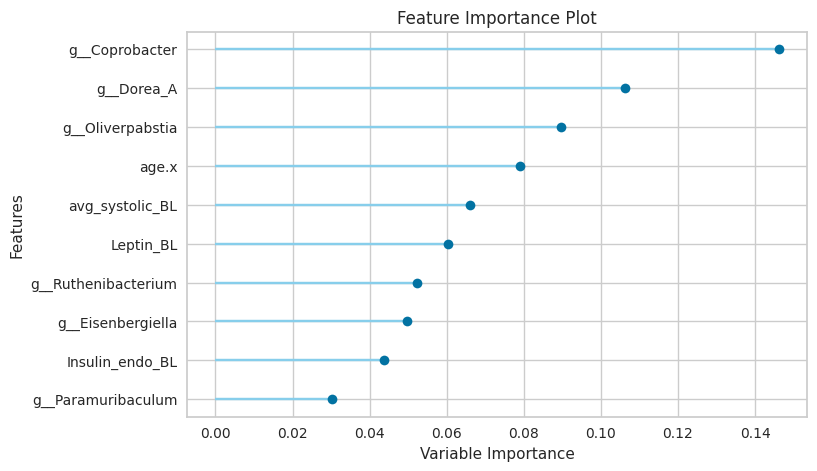

In [11]:
from pycaret.regression import *

# Initialize the setup
data = taxa_dict["genus"]["clr"]["latent_and_genus_species"]

best = run_pycaret(data, 'differences_BL_BMI')

print(best)
# evaluate_model(best)
plot_model(best, plot = 'feature')

# predictions = predict_model(best, data=data)
# predictions.head
# save_model(best, 'my_best_pipeline')

# TODO: \
# setup()
#   do we want to include PCA? or other lower dimensional representations of the data?
#   do we want to include feature selection? if so, how many features do we want to select?
# compare_models()
#   what models do we want to compare? (we can include a list of models to compare)
#   similary we can exclude models from the comparison
# create_model()
#   do we want to create and tune a specific model? 
#   if so, what model do we want to create and tune?
#   we would use the argument tume_model()
# blend_models()
#   do we want to blend models? if so, which models do we want to blend?
#   we would use the argument estimator_list
#   we would do this using top_5 = compare_models(n_select=5), then blend_models(top_5)
# stack_models()
#   do we want to stack models? if so, which models do we want to stack?
#   we would use the argument estimator_list
#   we would do this using top5 = compare_models(n_select=5), then stack_models(top5)


pycaret regression  
    using only genus clr factors

,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 546)"
4,Transformed data shape,"(145, 546)"
5,Transformed train set shape,"(101, 546)"
6,Transformed test set shape,"(44, 546)"
7,Numeric features,545
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,3.1707,17.1895,3.9556,0.0877,0.7906,1.8734,9.0520
gbr,Gradient Boosting Regressor,3.3007,17.7726,4.0636,0.0182,0.8095,2.2502,0.2090
ada,AdaBoost Regressor,3.4105,18.4782,4.1756,-0.0427,0.8542,1.5646,0.1120
et,Extra Trees Regressor,3.4172,18.9905,4.2572,-0.1025,0.9404,1.4483,0.0970
rf,Random Forest Regressor,3.5271,19.7944,4.3174,-0.1052,0.9100,1.7648,0.1450
dummy,Dummy Regressor,3.6879,20.9101,4.4226,-0.1104,1.3576,1.0984,0.0560
llar,Lasso Least Angle Regression,3.6684,22.7261,4.6229,-0.3224,0.8442,2.0042,0.0480
lasso,Lasso Regression,3.6684,22.7261,4.6229,-0.3224,0.8442,2.0045,0.0500
knn,K Neighbors Regressor,3.8919,24.3401,4.7995,-0.3926,0.8023,2.0465,0.0720
en,Elastic Net,4.1483,27.3670,5.1291,-0.7960,0.8069,2.2951,0.0500


LGBMRegressor(n_jobs=-1, random_state=123)


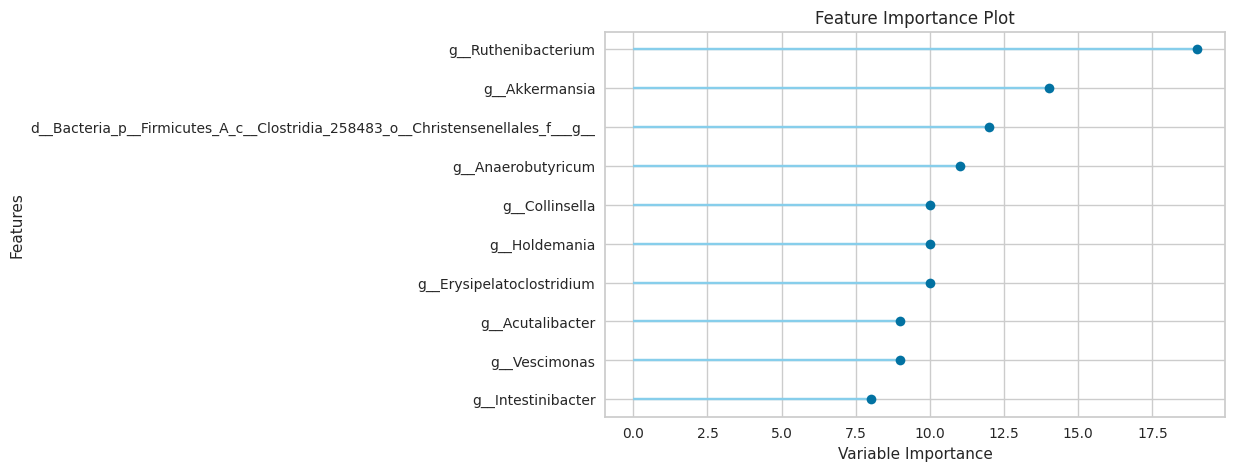

In [13]:

# Initialize the setup
data = taxa_dict["genus"]["clr"]["species_genus"]

best = run_pycaret(data, 'differences_BL_BMI')

print(best)
# evaluate_model(best)
plot_model(best, plot = 'feature')

# predictions = predict_model(best, data=data)
# predictions.head
# save_model(best, 'my_best_pipeline')

,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 24)"
4,Transformed data shape,"(145, 24)"
5,Transformed train set shape,"(101, 24)"
6,Transformed test set shape,"(44, 24)"
7,Numeric features,23
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.1804,8.1387,2.7770,0.3895,0.6382,2.0438,0.0110
lasso,Lasso Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0616,0.0150
llar,Lasso Least Angle Regression,2.1683,8.1528,2.7881,0.3805,0.6376,2.0617,0.0120
br,Bayesian Ridge,2.1937,8.5080,2.8553,0.3687,0.6360,2.0151,0.0110
ada,AdaBoost Regressor,2.5435,9.4067,3.0437,0.3149,0.7162,1.9602,0.0260
et,Extra Trees Regressor,2.5962,10.3196,3.1822,0.2833,0.7011,1.9919,0.0360
rf,Random Forest Regressor,2.7482,10.9544,3.2807,0.2480,0.7327,1.9650,0.0570
huber,Huber Regressor,2.4627,10.4561,3.1146,0.2448,0.7037,2.0920,0.0160
ridge,Ridge Regression,2.5434,11.0912,3.2641,0.2397,0.6823,2.5446,0.0130
gbr,Gradient Boosting Regressor,2.6752,10.6809,3.2394,0.1744,0.7197,2.2517,0.0260


ElasticNet(random_state=123)


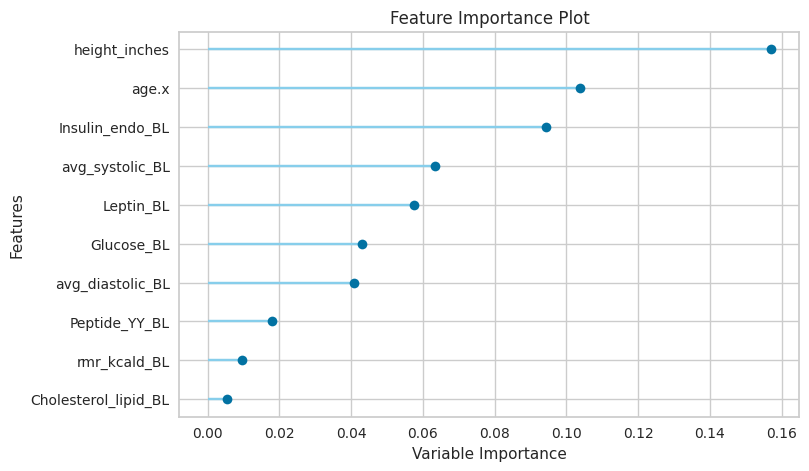

In [14]:

data = taxa_dict["genus"]["clr"]["latent"]

best = run_pycaret(data, 'differences_BL_BMI')

print(best)
# evaluate_model(best)
plot_model(best, plot = 'feature')

# predictions = predict_model(best, data=data)
# predictions.head
# save_model(best, 'my_best_pipeline')

In [18]:
df = taxa_dict["genus"]["clr"]["latent_and_genus_species"]
# Set up the environment
exp_name = setup(
    data=df,
    target='differences_BL_BMI',
    session_id=123,
)

models = create_model('lr', fold=5)


,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 569)"
4,Transformed data shape,"(145, 102)"
5,Transformed train set shape,"(101, 102)"
6,Transformed test set shape,"(44, 102)"
7,Numeric features,568
8,Rows with missing values,5.5%
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9663165601.3945,171950610897283055616.0000,13112993971.5262,-8352110003499694080.0000,20.1827,23574969821.0367
1,11009164745.6546,208065049234865946624.0000,14424460102.0234,-12716682699444211712.0000,20.5123,37661448491.3913
2,22427285521.7266,743787218115821436928.0000,27272462633.8697,-60389106533634842624.0000,22.4588,23033949791.1793
3,24452850806.4172,1408757422612513816576.0000,37533417411.8546,-100876831498265280512.0000,21.2988,10407979400.2428
4,3983432781.2426,28501700680075829248.0000,5338698406.9224,-784680118925598208.0000,19.6860,2751093654.7985
Mean,14307179891.2871,512212400308111998976.0000,19536406505.2393,-36623882170753929216.0000,20.8277,19485888231.7297
Std,7847219645.0120,509839113974996992000.0000,11425463717.9484,38336726720083206144.0000,0.9697,12017671139.7102


In [14]:
best = compare_models()

Lasso(random_state=123)

In [18]:
from pycaret.regression import RegressionExperiment

exp = RegressionExperiment()

df = taxa_dict["genus"]["clr"]["latent_and_genus_species"]

exp.setup(data=df, target='differences_BL_BMI', session_id=123)

best = exp.compare_models()
lasso = exp.create_model('lasso')

,Description,Value
0,Session id,123
1,Target,differences_BL_BMI
2,Target type,Regression
3,Original data shape,"(145, 569)"
4,Transformed data shape,"(145, 569)"
5,Transformed train set shape,"(101, 569)"
6,Transformed test set shape,"(44, 569)"
7,Numeric features,568
8,Rows with missing values,5.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,2.3825,9.7298,3.0454,0.2752,0.6722,2.1355,0.4790
llar,Lasso Least Angle Regression,2.3825,9.7302,3.0454,0.2752,0.6722,2.1355,0.4580
et,Extra Trees Regressor,2.8579,12.6537,3.4789,0.2345,0.7983,1.8485,0.1010
ada,AdaBoost Regressor,2.7790,11.6556,3.3713,0.2033,0.7548,2.2230,0.1240
lightgbm,Light Gradient Boosting Machine,2.8123,11.5427,3.3424,0.1906,0.7437,2.7451,8.8420
rf,Random Forest Regressor,3.0384,13.0804,3.5580,0.1718,0.8063,2.4641,0.1330
knn,K Neighbors Regressor,2.9696,13.5377,3.6214,0.1507,0.7031,2.1489,0.0770
en,Elastic Net,2.6233,11.8293,3.3440,0.1390,0.7042,2.2130,0.4550
huber,Huber Regressor,2.6399,11.4044,3.2828,0.1168,0.7075,2.4823,0.0770
gbr,Gradient Boosting Regressor,3.0312,13.4244,3.6044,0.0534,0.8083,3.0157,0.2420


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3232,9.3137,3.0518,0.5366,0.5567,2.2061
1,3.2936,13.9604,3.7364,0.3378,0.7760,0.9936
2,3.5952,16.2805,4.0349,-0.3834,1.1003,5.4369
3,1.6369,7.8079,2.7943,0.4743,0.3443,3.4104
4,2.0034,7.9860,2.8260,-1.3434,0.8642,4.9177
5,2.6766,13.0084,3.6067,0.3849,0.8693,0.9648
6,1.2143,2.3984,1.5487,0.8460,0.4244,0.5023
7,2.0076,6.2792,2.5058,0.4913,0.5376,0.7468
8,2.8186,11.6085,3.4071,0.6303,0.5894,0.9394


In [1]:
# print(lasso.get_params())
# help(lasso)
# plot_model(lasso, plot = 'feature').
# help(plot_model)
evaluate_model(lasso)

NameError: name 'plot_model' is not defined